In [ ]:
import pandas as pd
import numpy as np
import json
import persian
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import hazm
import time
import sys
import warnings
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn import preprocessing

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from skopt  import BayesSearchCV 

import xgboost as xgb
import lightgbm as lgb

# Read Data

In [3]:
path = '/home/asma/Desktop/Divaar/javaneh_amlak/Amlak/'

validation = pd.read_csv(path + 'validation.csv')
train_labels = pd.read_csv(path + 'train_labels.csv')

action_logs = pd.read_parquet(path + 'action_logs.parquet')
ladder = pd.read_parquet(path + 'ladder.parquet')
posts = pd.read_parquet(path+ 'posts.parquet')

image_features = pd.read_csv(path+ 'images_features.csv').drop(['Unnamed: 0'], axis=1)

# Clean Data

In [4]:
image_features = image_features.sort_values(by=['token', 'image_num']).reset_index(drop=True)
image_features = image_features.drop_duplicates(subset=['token'],keep='first')
image_features.head(3)

,dullness,whiteness,image_size,width,height,blurrness,token,image_num
0,0.0,2.365,68299,600,600,1809.952067,AY-RNJEr,0.jpg
9,0.0,0.000,90407,600,600,2881.315465,AY-ncLKW,0.jpg
10,36.2,44.145,69763,600,600,1394.461501,AY0DAuv8,0.jpg


In [5]:
action_logs = action_logs.reset_index(drop=True)
action_logs['ds'] = pd.to_datetime(action_logs['ds'])
action_logs['by_overuser'] = action_logs['by_overuser'].fillna(False)

# Extract Features

In [6]:
def get_action_features(group):
    
    total = group.shape[0]
    clicks = group[group['action']=='click_post'].shape[0] 
    contacts = group[group['action']=='click_contact'].shape[0] / clicks
    bookmarks = group[group['action']=='click_bookmark'].shape[0]/ clicks
    by_overusers = group[group['by_overuser']].shape[0] / total
    
    return total, clicks, contacts, bookmarks, by_overusers

In [7]:
tokens_action = action_logs.groupby('token')\
                           .apply(lambda group: get_action_features(group))\
                           .reset_index()
tokens_action = pd.concat([tokens_action.drop(0 , axis=1), tokens_action[0].apply(pd.Series)], axis=1)\
                   .rename({0: 'total_actions', 1: 'clicks', 2: 'contacts', 3: 'bookmarks', 4: 'by_overusers'}, axis=1)

In [8]:
def find_pre_category(posts):
    
    residential_sell = ['apartment-sell', 'house-villa-sell', 'plot-old']
    residential_rent = ['apartment-rent', 'house-villa-rent']
    commercial_sell  = ['office-sell', 'shop-sell','industry-agriculture-business-sell']
    commercial_rent  = ['office-rent', 'shop-rent','industry-agriculture-business-rent']
    short_term_rent  = ['suite-apartment', 'villa', 'workspace'] 
    construction     = ['partnership', 'presell']

    conditions = [
        posts['category'].isin(residential_sell),
        posts['category'].isin(residential_rent),
        posts['category'].isin(commercial_sell),
        posts['category'].isin(commercial_rent),
        posts['category'].isin(short_term_rent),
        posts['category'].isin(construction)]
    
    choices = ['residential_sell', 'residential_rent', 'commercial_sell', 'commercial_rent', 'short_term_rent', 'construction']
    
    posts['pre_category'] = np.select(condlist=conditions, choicelist=choices, default='other')
    
    return posts['pre_category']

In [9]:
def extract_from_data_posts(posts_data):
    
    posts = posts_data.copy()
    
    posts['data'] = posts['data'].apply(lambda x:json.loads(x))
    posts = pd.concat([posts.drop(['data'], axis=1), posts['data'].apply(pd.Series)], axis=1)
    #posts = pd.concat([posts.drop(['price'], axis=1), posts['price'].apply(pd.Series)], axis=1)
    #posts.drop(0,inplace = True,axis = 1)
    #posts.value = posts.value/(10**6)
    cat = posts.category.iloc[:,1]
    posts.drop('category',inplace = True,axis = 1)
    posts['category'] = cat
    drop_columns = ['job_title', 'exchange', 'deed_type', 'bizzDeed', 'zoonkan_enabled',\
                    'national_id', 'property_type', 'daily_rent', 'desc']
    posts = posts.drop(drop_columns, axis=1, errors='ignore')
    
    return posts                              

In [10]:
def extract_from_contact(data):
    
    conditions = [
        data['contact']=={'chat_enable': 'false', 'chat_enabled': False},
        data['contact']=={'hide_phone': False, 'chat_enabled': True},
        (data['contact']!={'chat_enabled': False}) & (data['contact']!={'chat_enabled': True})]
    
    choices = [
        {'chat_enabled': False},
        {'chat_enabled': True},
        {'chat_enabled': False}]
    
    data['contact'] = np.select(condlist=conditions, choicelist=choices, default= data['contact']) 
    data = pd.concat([data.drop(['contact'], axis=1), data['contact'].apply(pd.Series)], axis=1)
    
    return data['chat_enabled'].astype(int)

In [11]:
def handle_year (data):
    
    string_year = 'قبل از ۱۳۷۰'
    data['year'] = np.where(data['year']== string_year, 1369, data['year'])
    data['year'] = data['year'].apply(lambda x:persian.convert_fa_numbers(x))
    data['year'] = np.where(data['year']=='nan', -1, data['year'])
    data['year'] = pd.to_numeric(data['year'])
    
    return data['year']

In [12]:
def find_username_category(group):
    
    #print(group)
    total_posts = group.shape[0]
    fake_posts = group[group['result']=='fake-post'].shape[0]
    min_posts = 3
    min_fake_ratio = 0.5
    username_category = "defult"
    
    if (total_posts<min_posts):
        username_category = 'without_history'
        
    elif ((fake_posts/ total_posts) > min_fake_ratio):
        username_category = 'BAD'
        
    else:
        username_category = 'Ok'

    return username_category       

In [13]:
def username_category (train_data, validation_data, is_train=True):
    
    if (is_train==True):
        data = train_data.copy()
        username_df = data.groupby(['username'])\
                            .apply(lambda group:find_username_category(group))\
                            .reset_index()\
                            .rename({0:'username_category'}, axis=1)

        data = data.merge(username_df, on='username', how='left')
    
    else:
        data = validation_data.copy()
        user_df = train_data[['username_category', 'username']].drop_duplicates(['username'])
        data = data.merge(user_df, on='username', how='left')
        
    return data['username_category'].fillna('without_history')

In [14]:
def is_rent(data):
    
    conditions = [
        ((data['pre_category'] == 'residential_sell')|
        (data['pre_category'] == 'commercial_sell') |
        (data['pre_category'] == 'construction')    |
        (data['pre_category'] == 'short_term_rent'))]
    
    choices = [0]
    
    data['is_rent'] = np.select(condlist= conditions, choicelist=choices, default=1)
    
    return data['is_rent']

In [15]:
def rent_features(data):
    
    data = data.copy()
    data['rent_credit_transform'] = np.where(data['is_rent']==0, 'sell', data['rent_credit_transform'])
    data['rent_to_single'] = np.where(data['is_rent']==0, 'sell', data['rent_to_single'])
    data['rent_type'] = np.where(data['is_rent']==0, 'sell', data['rent_type'])
    data['rent_to_single'] = data['rent_to_single'].fillna('false')
    
    return data

In [16]:
def handle_image_featuters(data):
    
    data = data.copy()
    blurriness_median = data['blurrness'].median()
    width_median = data['width'].median()
    
    b_conditions = [
        (data['blurrness'].isnull()),
        (data['blurrness']<=blurriness_median),
        (data['blurrness']>blurriness_median)]
    
    b_choices = [
        'no_images',
        'low_blurrness',
        'high_blurness']
    
    w_conditions = [
        (data['width'].isnull()),
        (data['width']<=width_median),
        (data['width']>width_median)]
    
    w_choices = [
        'no_images',
        'low_width',
        'high_width']
    
    data['blurriness_cat'] = np.select(condlist=b_conditions, choicelist=b_choices)
    data['width_cat'] = np.select(condlist=w_conditions, choicelist=w_choices)
 
    
    
    return data['blurriness_cat'], data['width_cat']

In [17]:
def handle_actions_features(data):
    
    data = data.copy()
    
    contact_median = data['contacts'].median()
    by_overuser_q3 = data['by_overusers'].quantile(0.75)
    bookmarks_median = data['bookmarks'].median()
    
    data['contacts_boolean'] = np.where(data['contacts']< contact_median, 0, 1) 
    data['by_overuser_boolean'] = np.where(data['by_overusers']> by_overuser_q3, 0, 1)
    data['bookmark_boolean'] = np.where(data['bookmarks']< bookmarks_median, 0, 1)

    return data['contacts_boolean'], data['by_overuser_boolean'], data['bookmark_boolean']

In [18]:
def find_price(row):
    
    if (row['is_rent']):
        row['new_credit'] = row['new_credit'] +  (row['new_rent']/3000000) * 100000000
        price = row['new_credit']* 6
    else:
        price = row['new_price']
    
    return np.log(price)

In [19]:
def count_real_words(text):
    normalizer = hazm.Normalizer()
    normalizer.normalize(text)
    words = hazm.word_tokenize(text)
    real_words = []
    
    for word in words:
        if (len(str(word)))>2:
            real_words.append(word)
            
    return len(real_words)

In [20]:
def handle_rooms(data):
    
    string0 = 'بدون اتاق'
    string1 = 'یک'
    string2 = 'دو'
    string3 = 'سه'
    string4 = 'چهار'
    string5 = 'پنج یا بیشتر'
    
    rooms_map = {
        string0 : 0,
        string1 : 1,
        string2 : 2,
        string3 : 3,
        string4 : 4,
        string5 : 5 }
    
    return data['rooms'].map(rooms_map).fillna(2)

In [21]:
def extract_features(train_data, validation_data, is_train):
    
    if (is_train):
        data = train_data.copy()
    else:
        data = validation_data.copy()
    
    
    data = extract_from_data_posts(data)

    data['text'] = data['title'] + data['description']
    data['words_count'] = data['text'].apply(lambda s: count_real_words(s))
    data['rooms'] = handle_rooms(data)
  
    data['username_category'] = username_category(train_data, validation_data, is_train)
    
    data['contacts_boolean'], data['by_overuser_boolean'], data['bookmark_boolean'] = handle_actions_features(data)
    data['blurriness_cat'], data['width_cat'] = handle_image_featuters(data)
    data['chat_enabled'] = extract_from_contact(data)
    data['year'] = handle_year(data)

    data['full_options'] = np.where(((data['parking']=='true')\
                                     & (data['elevator']=='true')\
                                     & (data['warehouse']=='true')), 1, 0) 

    data['is_new'] = np.where(data['year']>1390, 1, 0)
    data['pre_category'] = find_pre_category(data)    
    data['is_rent'] = is_rent(data)
    data = rent_features(data)
    
    data['published_year'] = data['first_published_at'].dt.year
    data['published_dayofweek'] = data['first_published_at'].dt.dayofweek
    data['published_hour'] = data['first_published_at'].dt.hour
    data['published_year'] = np.where(data['published_year']<2021, 2021, data['published_year'])
    data['published_year'] = np.where(data['published_year']==2021, 0, 1)
    data['published_month'] = data['first_published_at'].dt.month
    data['published_season'] = np.where(data['published_month']<4, 1, 0)
    
    data['image_count'] = data['image_count'].astype(int)
    data['is_agent'] = np.where(data['username'].isnull(), 1, 0)
    data['is_tehran'] = np.where(data['city']=='tehran', 1, 0) 
    data['is_niavaran'] = np.where(data['district']=='niavaran', 1, 0)
    user_type_string = 'شخصی'
    data['user_type'] = np.where(data['user_type']==user_type_string, 0, 1) #is_agent
    
    
    data['total_price'] = data.apply(lambda row:  find_price(row), axis=1)
    data['total_price'] = data['total_price'].fillna(data['total_price'].median())

    
    return data

In [22]:
def handle_missing_values(data):
    
    missing_values = {
        'dullness' : -1,
        'whiteness' : -1,
        'image_size': -1,
        'width': -1,
        'height': -1,
        'blurrness': -1,
        'size': data['size'].median(),
        'rent_type': 'rent_credit'}
    
    return data.fillna(missing_values)

In [23]:
def get_full_data(train_data, test_data, is_train):
    
    if (is_train):
        data = train_data.copy()
        
    else:
        data = test_data.copy()
    
    data = data.merge(posts, on='token', how='left')
    data = data.merge(image_features, on= 'token', how='left')
    data = data.merge(tokens_action, on='token', how='left')
    
    if(is_train):
        data = data.dropna(subset=['first_published_at']).reset_index(drop=True)
        data = extract_features(data, test_data, is_train)
    else:
        data = extract_features(train_data, data, is_train)
    
    data = handle_missing_values(data)
    
    return data

In [24]:
train_full_data = get_full_data(train_labels, validation, True)
validation_full_data = get_full_data(train_full_data, validation, False)

In [25]:
def drop_useless_columns(data, is_train):
    
    drop_list = ['token', 'first_published_at', 'device_id', 'user_hash',
                 'retiredAtUtc', 'district', 'city', 'username', 'call_date', 'category',
                 'image_num',
                 'contact',
                 'parking', 'elevator', 'warehouse',
                 'title', 'description', 'text',
                 'floor',
                 'rent', 'price', 'credit', 'new_rent', 'new_credit', 'new_price',
                 'other_options_and_attributes', 'balcony']
    
    if (is_train):
        drop_list.append('tag')
        
    return data.drop(drop_list, axis=1)

In [26]:
train_full_data = drop_useless_columns(train_full_data, True)
validation_full_data = drop_useless_columns(validation_full_data, False)

In [27]:
train_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   result                 5999 non-null   object 
 1   image_count            5999 non-null   int64  
 2   dullness               5999 non-null   float64
 3   whiteness              5999 non-null   float64
 4   image_size             5999 non-null   float64
 5   width                  5999 non-null   float64
 6   height                 5999 non-null   float64
 7   blurrness              5999 non-null   float64
 8   total_actions          5999 non-null   float64
 9   clicks                 5999 non-null   float64
 10  contacts               5999 non-null   float64
 11  bookmarks              5999 non-null   float64
 12  by_overusers           5999 non-null   float64
 13  size                   5999 non-null   float64
 14  year                   5999 non-null   int64  
 15  room

In [28]:
validation_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image_count            2172 non-null   int64  
 1   dullness               2172 non-null   float64
 2   whiteness              2172 non-null   float64
 3   image_size             2172 non-null   float64
 4   width                  2172 non-null   float64
 5   height                 2172 non-null   float64
 6   blurrness              2172 non-null   float64
 7   total_actions          2172 non-null   float64
 8   clicks                 2172 non-null   float64
 9   contacts               2172 non-null   float64
 10  bookmarks              2172 non-null   float64
 11  by_overusers           2172 non-null   float64
 12  size                   2172 non-null   float64
 13  year                   2172 non-null   int64  
 14  rooms                  2172 non-null   float64
 15  user

In [29]:
X_train_full = train_full_data.drop('result', axis=1)
y_train_full = train_full_data['result'].map({'ok': 0, 'fake-post': 1})

# Encode Categoricals and Normalize Numerics

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [31]:
def encode_categorical_features(data):
    
    df=data.copy()
    data_cat = data.select_dtypes(include=[object])
    cat_columns = list(data_cat.columns)
    onehotencoder = OneHotEncoder()
    #print(cat_columns)
    for column in cat_columns:
        X = onehotencoder.fit_transform(data[column].values.reshape(-1,1)).toarray()
        dfOneHot = pd.DataFrame(X, columns = [str(column)+str(int(i)) for i in range(data[column].nunique())])
        #print(dfOneHot)
        df = pd.concat([df, dfOneHot], axis=1)
        df = df.drop([column], axis=1) 
        #print(df.shape)
            
    return df

In [32]:
def scale_data (data):
    
    df = data.copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    df = pd.DataFrame(scaled_data, columns=df.columns)
    
    return df

In [33]:
X_train_full = encode_categorical_features(X_train_full)
validation_full = encode_categorical_features(validation_full_data)
X_train_full = scale_data(X_train_full)
validation_full = scale_data(validation_full)

In [34]:
X_train_full.shape

(5999, 57)

In [35]:
validation_full.shape

(2172, 57)

# Feature Selection

In [36]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [37]:
categoricals= ['username_category', 'pre_category',
               'width_cat', 'blurriness_cat',
               'rent_credit_transform', 'rent_to_single', 'rent_type']

## Information Gain

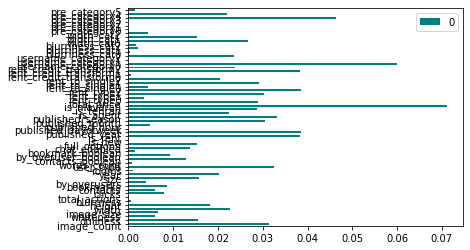

In [38]:
importances = mutual_info_classif(X_train_full, y_train_full)
featur_importance = pd.DataFrame(importances, X_train_full.columns)
featur_importance.plot(kind='barh', color='teal')
plt.rcParams["figure.figsize"] = (20,15)
plt.show()

## Random Forest

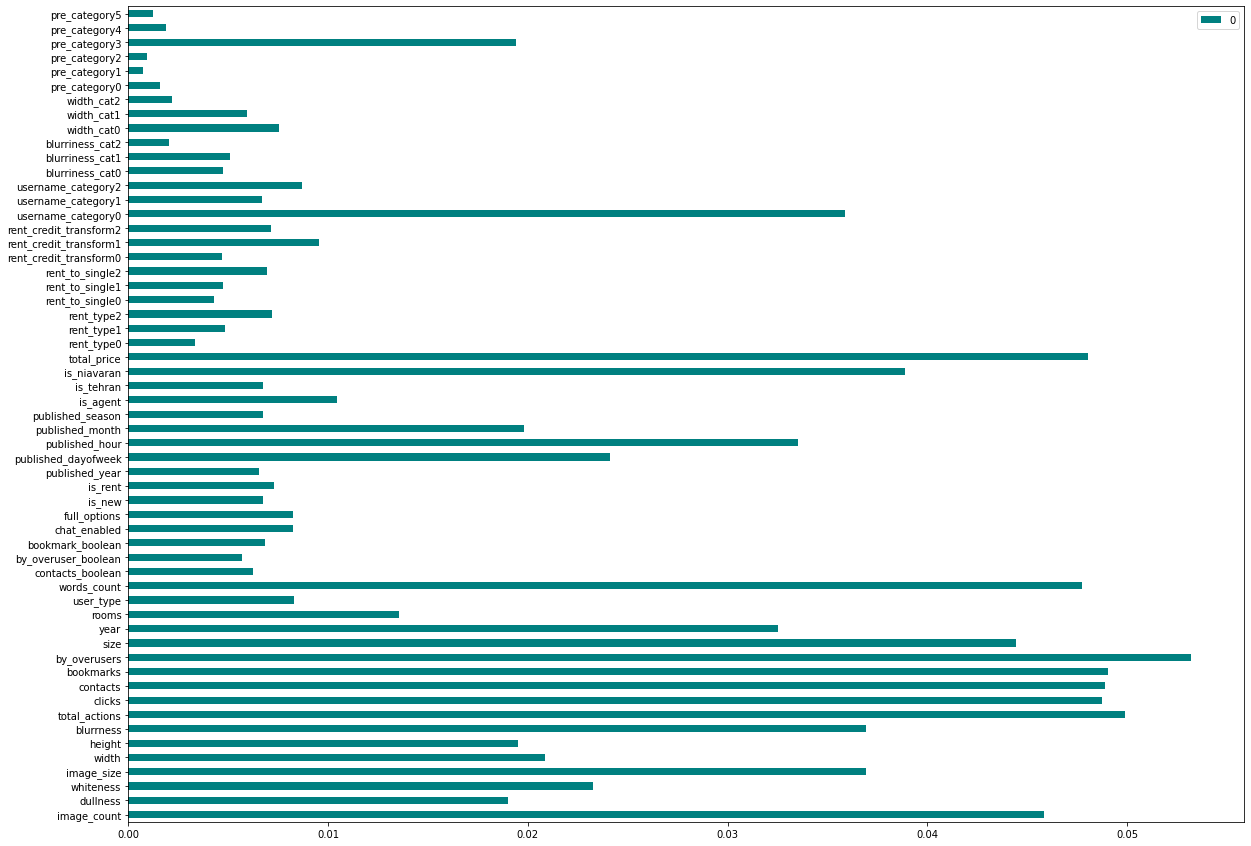

In [39]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier().fit(X_train_full, y_train_full)
importances = random_forest.feature_importances_
featur_importance = pd.DataFrame(importances, X_train_full.columns)
featur_importance.plot(kind='barh', color='teal')
plt.rcParams["figure.figsize"] = (10, 50)
plt.show()

## Correlation Coefficient

<AxesSubplot:>

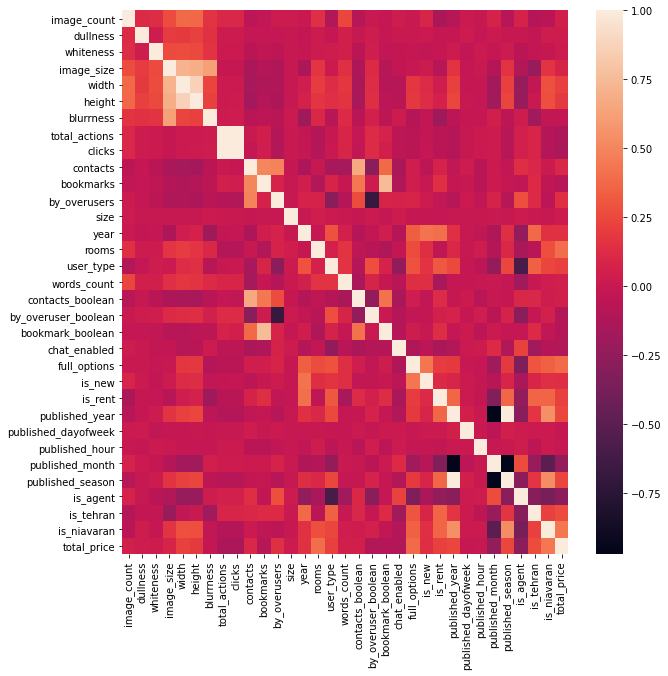

In [40]:
cor = train_full_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(cor)

In [41]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image_count             5999 non-null   float64
 1   dullness                5999 non-null   float64
 2   whiteness               5999 non-null   float64
 3   image_size              5999 non-null   float64
 4   width                   5999 non-null   float64
 5   height                  5999 non-null   float64
 6   blurrness               5999 non-null   float64
 7   total_actions           5999 non-null   float64
 8   clicks                  5999 non-null   float64
 9   contacts                5999 non-null   float64
 10  bookmarks               5999 non-null   float64
 11  by_overusers            5999 non-null   float64
 12  size                    5999 non-null   float64
 13  year                    5999 non-null   float64
 14  rooms                   5999 non-null   

In [42]:
drop_list = ['dullness', 'whiteness', 'image_size', 'total_actions', 'clicks', 'contacts',
             'by_overusers', 'contacts_boolean', 'is_new', 'published_hour', 'pre_category2','pre_category1', 'pre_category0',
             'width_cat2', 'blurriness_cat2', 'username_category1', 'rent_credit_transform0', 'user_type', 'contacts_boolean',
             'by_overuser_boolean', 'bookmark_boolean', 'chat_enabled',
             'rent_to_single0', 'rent_type0', 'published_hour', 'published_year', 'published_month', 'chat_enabled']

In [43]:
X_train_data = X_train_full.drop(drop_list, axis=1)
validation_data = validation_full.drop(drop_list, axis=1)

# Split Train and Test

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_full,
                                                    stratify=y_train_full, 
                                                    test_size=0.2)

In [46]:
test_df = X_test.join(train_labels)
train_df = X_train.join(train_labels)

In [47]:
X_train.shape

(4799, 32)

In [48]:
X_test.shape

(1200, 32)

In [49]:
def get_roc_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    y_predict_prob = model.predict_proba(X_test)
    y_predict_fake_prob = [prob[1] for prob in y_predict_prob]
    return roc_auc_score(y_test, y_predict_fake_prob)

In [50]:
random_forest = RandomForestClassifier()
get_roc_score(random_forest, X_train, y_train, X_test, y_test)

0.7726240669346238

# Model Selection

In [52]:
scoring = ['accuracy', 'precision', 'recall' , 'f1_weighted', 'roc_auc']

### Decision Tree

In [53]:
decision_tree = DecisionTreeClassifier()

scores = cross_validate(decision_tree, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision'].mean()
dtree_recall = scores['test_recall'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()
dtree_test_score =  get_roc_score(decision_tree, X_train, y_train, X_test, y_test)

### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)
scores = cross_validate(LR, X_train, np.ravel(y_train), scoring=scoring, cv=5)


sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision'].mean()
LR_recall = scores['test_recall'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()
LR_test_score =  get_roc_score(LR, X_train, y_train, X_test, y_test)

### Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
scores = cross_validate(random_forest, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision'].mean()
forest_recall = scores['test_recall'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()
forest_test_score =  get_roc_score(random_forest, X_train, y_train, X_test, y_test)

### Support Vector Machine

In [56]:
from sklearn.svm import SVC

SVM = SVC(probability=True)
scores = cross_validate(SVM, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision'].mean()
SVM_recall = scores['test_recall'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()
SVM_test_score =  get_roc_score(SVM, X_train, y_train, X_test, y_test)

### K Nearest Neighbors

In [57]:
from sklearn.neighbors import KNeighborsClassifier
 
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
scores = cross_validate(KNN, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision'].mean()
KNN_recall = scores['test_recall'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()
KNN_test_score =  get_roc_score(KNN, X_train, y_train, X_test, y_test)

### XGboost

In [58]:
XGB = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
scores = cross_validate(XGB, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
XGB_fit_time = scores['fit_time'].mean()
XGB_score_time = scores['score_time'].mean()
XGB_accuracy = scores['test_accuracy'].mean()
XGB_precision = scores['test_precision'].mean()
XGB_recall = scores['test_recall'].mean()
XGB_f1 = scores['test_f1_weighted'].mean()
XGB_roc = scores['test_roc_auc'].mean()
XGB_test_score =  get_roc_score(XGB, X_train, y_train, X_test, y_test)

### LightGBM

In [59]:
LGBM = lgb.LGBMClassifier()
scores = cross_validate(LGBM, X_train, np.ravel(y_train), scoring=scoring, cv=5)

sorted(scores.keys())
lgb_fit_time = scores['fit_time'].mean()
lgb_score_time = scores['score_time'].mean()
lgb_accuracy = scores['test_accuracy'].mean()
lgb_precision = scores['test_precision'].mean()
lgb_recall = scores['test_recall'].mean()
lgb_f1 = scores['test_f1_weighted'].mean()
lgb_roc = scores['test_roc_auc'].mean()
lgb_test_score =  get_roc_score(LGBM, X_train, y_train, X_test, y_test)

In [60]:
models_initial = pd.DataFrame({
    'Model': ['Decison Tree', 'Logistic Regression', 'Support Vector Machine', 'Random Forest',
              'K-Nearest Neighbors', 'XGBoost', 'LightGBM'],
    'Fitting time': [dtree_fit_time, LR_fit_time, SVM_fit_time, forest_fit_time, KNN_fit_time, XGB_fit_time, lgb_fit_time],
    'Scoring time': [dtree_score_time, LR_score_time, SVM_score_time, forest_score_time, KNN_score_time, XGB_score_time,
                     lgb_score_time],
    'Accuracy'    : [dtree_accuracy, LR_accuracy, SVM_accuracy, forest_accuracy, KNN_accuracy, XGB_accuracy, lgb_accuracy],
    'Precision'   : [dtree_precision,LR_precision, SVM_precision, forest_precision, KNN_precision, XGB_precision,
                     lgb_precision],
    'Recall'      : [dtree_recall, LR_recall, SVM_recall, forest_recall, KNN_recall, XGB_recall, lgb_recall],
    'F1_score'    : [dtree_f1, LR_f1, SVM_f1, forest_f1, KNN_f1, XGB_f1, lgb_f1],
    'AUC_ROC'     : [dtree_roc, LR_roc, SVM_roc, forest_roc, KNN_roc, XGB_roc, lgb_roc],
    'Test_AUC_ROC': [dtree_test_score, LR_test_score, SVM_test_score, forest_test_score, KNN_test_score, XGB_test_score,
                     lgb_test_score]
    },
    columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy',
               'Precision', 'Recall', 'F1_score', 'AUC_ROC', 'Test_AUC_ROC'])

models_initial.sort_values(by='Test_AUC_ROC', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC,Test_AUC_ROC
3,Random Forest,0.398496,0.041427,0.769743,0.728610,0.388227,0.745232,0.757734,0.771121
6,LightGBM,0.107976,0.009307,0.773077,0.708235,0.434164,0.754767,0.752554,0.770444
5,XGBoost,0.169371,0.007739,0.751615,0.634742,0.432766,0.736273,0.729087,0.757887
1,Logistic Regression,0.029059,0.005603,0.774535,0.769270,0.369009,0.746345,0.758592,0.750970
2,Support Vector Machine,1.772489,0.173177,0.775996,0.808054,0.345001,0.743485,0.744287,0.746216
4,K-Nearest Neighbors,0.006643,0.218859,0.746196,0.612672,0.447194,0.733299,0.718036,0.722518
0,Decison Tree,0.026996,0.006045,0.686391,0.484074,0.500654,0.687716,0.634045,0.633656


In [ ]:
#models_initial.to_csv('models_performance_00.csv', index=False)

# Check Errors

In [61]:
def predict(model, X_train, y_train, X_test, y_test, train_labels):
    test = X_test.join(train_labels).drop('result', axis=1)
    test = pd.concat([test, y_test], axis=1)
    model.fit(X_train, y_train)
    test['predicted_class'] = model.predict(X_test)
    y_predict_prob = model.predict_proba(X_test)
    y_predict_fake_prob = [prob[1] for prob in y_predict_prob]
    test['fake_prob'] = y_predict_fake_prob
    
    return test[['token', 'tag', 'result', 'predicted_class', 'fake_prob']]

In [62]:
errors_df = predict(random_forest, X_train, y_train, X_test, y_test, train_labels)
errors_df['True'] = np.where(errors_df['result']!=errors_df['predicted_class'], 0, 1)

In [63]:
errors_df.head()

,token,tag,result,predicted_class,fake_prob,True
1312,QYGqSP53,NaN,1,1,0.60,1
2956,QY-ZiqgV,NaN,1,0,0.47,0
1391,QY4tgQIb,-,0,0,0.14,1
1138,QYleCeHs,NaN,0,0,0.10,1
4873,QY9mlJUs,NaN,0,1,0.52,0


In [64]:
errors_df['fake_prob'].describe()

count    1200.000000
mean        0.312875
std         0.231500
min         0.000000
25%         0.150000
50%         0.245000
75%         0.400000
max         0.990000
Name: fake_prob, dtype: float64

In [65]:
errors_df['True'].value_counts()

1    933
0    267
Name: True, dtype: int64

In [66]:
errors_df[(errors_df['True']==0) & (errors_df['result']==1)]['tag'].shape[0]

211

In [67]:
errors_df[(errors_df['True']==0) & (errors_df['result']==0)]['tag'].shape[0]

56

# Tuning Hyperparameters

In [117]:
def randomized_search(X_data, y_data, model, random_grid):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    random_search = RandomizedSearchCV(model, random_grid, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
    search_result = random_search.fit(X_data, np.ravel(y_data))

    print("Best: %f using %s" % (search_result.best_score_, search_result.best_params_))
    
    means = search_result.cv_results_['mean_test_score']
    fit_times = search_result.cv_results_['std_test_score']
    params = search_result.cv_results_['params']
    for mean, time, param in zip(means, fit_times, params):
        print("%f (%f) with: %r" % (mean, time, param))

In [118]:
def grid_search (X_data, y_data, model, grid):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(model, grid, scoring='roc_auc', n_jobs=-1, cv=cv)
    grid_result = grid_search.fit(X_data, np.ravel(y_data))

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    means = grid_result.cv_results_['mean_test_score']
    fit_times = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, time, param in zip(means, fit_times, params):
        print("%f (%f) with: %r" % (mean, time, param))

In [120]:
model = RandomForestClassifier()
n_estimators = range(50, 500, 50)
max_depth = [3, 4, 5]
min_samples_split = [0.05, 0.02, 0.01, 0.005]
min_samples_leaf = [0.01, 0.001, 0.025, ]
max_features = ['log2', 'sqrt']
grid = dict(n_estimators= n_estimators, max_depth = max_depth, min_samples_leaf= min_samples_leaf,
            max_features=max_features, min_samples_split=min_samples_split)
randomized_search(X_train, y_train, model, grid)

Best: 0.756601 using {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 5}
0.753296 (0.025501) with: {'n_estimators': 450, 'min_samples_split': 0.05, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 5}
0.750571 (0.025626) with: {'n_estimators': 450, 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 4}
0.756601 (0.025158) with: {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 5}
0.754718 (0.024172) with: {'n_estimators': 300, 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 4}
0.754797 (0.024808) with: {'n_estimators': 350, 'min_samples_split': 0.05, 'min_samples_leaf': 0.001, 'max_features': 'log2', 'max_depth': 5}
0.756263 (0.025287) with: {'n_estimators': 300, 'min_samples_split': 0.005, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 5}
0.743105 (0.02

In [150]:
model = RandomForestClassifier()
n_estimators = [350]
max_depth = [5, 6, 7]
min_samples_split = [0.006, 0.004, 0.005]
min_samples_leaf = [0.01, 0.005, 0.015 ]
max_features = ['log2']
grid = dict(n_estimators= n_estimators, max_depth = max_depth, min_samples_leaf= min_samples_leaf,
            max_features=max_features, min_samples_split=min_samples_split)
randomized_search(X_train, y_train, model, grid)

Best: 0.761548 using {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.005, 'max_features': 'log2', 'max_depth': 7}
0.751729 (0.021927) with: {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.015, 'max_features': 'log2', 'max_depth': 6}
0.759154 (0.021020) with: {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.005, 'max_features': 'log2', 'max_depth': 6}
0.756799 (0.021524) with: {'n_estimators': 350, 'min_samples_split': 0.006, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 7}
0.754624 (0.022000) with: {'n_estimators': 350, 'min_samples_split': 0.006, 'min_samples_leaf': 0.005, 'max_features': 'log2', 'max_depth': 5}
0.761548 (0.021468) with: {'n_estimators': 350, 'min_samples_split': 0.005, 'min_samples_leaf': 0.005, 'max_features': 'log2', 'max_depth': 7}
0.755010 (0.021596) with: {'n_estimators': 350, 'min_samples_split': 0.004, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 6}
0.7569

In [162]:
model = RandomForestClassifier()
n_estimators = [350]
max_depth = [40]
min_samples_split = [0.005]
min_samples_leaf = [0.005]
max_features = ['log2']
class_weight= [{1:1, 0:2}, {1:1, 0:1}, {1:1, 0:3}]
grid = dict(n_estimators= n_estimators, max_depth = max_depth, min_samples_leaf= min_samples_leaf,
            max_features=max_features, min_samples_split=min_samples_split, class_weight= class_weight)
grid_search(X_train, y_train, model, grid)

Best: 0.764311 using {'class_weight': {1: 1, 0: 1}, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 350}
0.763672 (0.021221) with: {'class_weight': {1: 1, 0: 2}, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 350}
0.764311 (0.021042) with: {'class_weight': {1: 1, 0: 1}, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 350}
0.763609 (0.020925) with: {'class_weight': {1: 1, 0: 3}, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 350}


In [159]:
random_forest = RandomForestClassifier(max_depth = 40, 
                                       max_features= 'log2',
                                       min_samples_leaf = 0.005,
                                       min_samples_split = 0.005,
                                       n_estimators= 350)
random_forest = random_forest.fit(X_train, y_train)

In [160]:
random_forest

RandomForestClassifier(max_depth=40, max_features='log2',
                       min_samples_leaf=0.005, min_samples_split=0.005,
                       n_estimators=350)

In [167]:
from bayes_opt import BayesianOptimization

In [172]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth,\
                 max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 15 µs


In [ ]:
bayes_parameter_opt_lgb(X_train, y_train)

0.763714066674901,
 {'bagging_fraction': 0.8525494246713672,
  'feature_fraction': 0.20020645279635316,
  'learning_rate': 0.14434668708405266,
  'max_bin': 36.079469594293414,
  'max_depth': 7.689472442994714,
  'min_data_in_leaf': 55.7673935086993,
  'min_sum_hessian_in_leaf': 62.297711718914115,
  'num_leaves': 49.510038695902644,
  'subsample': 0.7438387845838078})

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold
import optuna.integration.lightgbm as lgb
import optuna

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }
study_tuner = optuna.create_study(direction='maximize')
dtrain = lgb.Dataset(X_train_full, label=y_train_full)
data_cat = X_train.select_dtypes(include=[object])
cat_columns = list(data_cat.columns)
ids_of_categorical = cat_columns
dtrain = lgb.Dataset(X_train, label=y_train)

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgb.LightGBMTunerCV(params, 
                            dtrain, 
                            #categorical_feature=ids_of_categorical,
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=250,
                            time_budget=3000, # Time budget of 5 hours, we will not really need it
                            seed = 42,
                            folds=rkf,
                            num_boost_round=10000,
                            callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
                           )


tuner.run()


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

feature_fraction, val_score: 0.766955:  14%|#4        | 1/7 [02:17<13:44, 137.45s/it]'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

feature_fraction, val_score: 0.768691:  29%|##8       | 2/7 [03:11<07:22, 88.54s/it]'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass '

KeyboardInterrupt: 

In [180]:
LGBM = lgb.LGBMClassifier(bagging_fraction = 0.8525494246713672,
                          feature_fraction =  0.20020645279635316,
                          learning_rate = 0.14434668708405266,
                          max_bin = 36,
                          max_depth = 8,
                          min_data_in_leaf = 56,
                          min_sum_hessian_in_leaf = 62.297711718914115,
                          num_leaves = 49,
                          subsample = 0.7438387845838078)
get_roc_score(LGBM, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.20020645279635316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20020645279635316
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=62.297711718914115, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=62.297711718914115
[LightGBM] [Warning] bagging_fraction is set=0.8525494246713672, subsample=0.7438387845838078 will be ignored. Current value: bagging_fraction=0.8525494246713672


0.7742170453613322

In [183]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image_count             2172 non-null   float64
 1   width                   2172 non-null   float64
 2   height                  2172 non-null   float64
 3   blurrness               2172 non-null   float64
 4   bookmarks               2172 non-null   float64
 5   size                    2172 non-null   float64
 6   year                    2172 non-null   float64
 7   rooms                   2172 non-null   float64
 8   words_count             2172 non-null   float64
 9   full_options            2172 non-null   float64
 10  is_rent                 2172 non-null   float64
 11  published_dayofweek     2172 non-null   float64
 12  published_season        2172 non-null   float64
 13  is_agent                2172 non-null   float64
 14  is_tehran               2172 non-null   

In [46]:
def get_output(model, validation_full, validation):

    y_predict_prob = model.predict_proba(validation_full)
    y_predict_fake_prob = [prob[1] for prob in y_predict_prob]
 
    validation['prediction'] = y_predict_fake_prob
    out = validation[['token', 'prediction']]
    out.to_csv('output.csv', index=False)
    
    return out

In [184]:
get_output(LGBM, validation_data, validation)

,token,prediction
0,QYt9WGLi,0.238306
1,QYDaIXQH,0.157237
2,wX-DxjWR,0.146804
3,QYvPrbxo,0.288773
4,QYEP35DV,0.715496
...,...,...
2167,QYtGvCm5,0.120958
2168,QY7dxpU8,0.170491
2169,QYjuJcr9,0.517789
2170,QYkO40a0,0.309350
